In [1]:
# ignore unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import LeaveOneOut
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from ISLP import load_data, confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split, LeaveOneOut, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score, precision_score, auc, f1_score, recall_score
from sklearn import neighbors
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from ISLP import load_data, confusion_table
import sklearn.linear_model as skl
from sklearn.neighbors import KNeighborsClassifier

In [3]:
dataset = pd.read_csv("C:\\Bayes Business School\\Machine Learning//heart-disease (1).csv")

In [4]:
# Print the type of the dataset object using f-string formatting
print(f'Type: {type(dataset)}')

# Print the keys (column names) of the dataset using f-string formatting
print(f'Keys: {dataset.keys()}')

# Print the type of the dataset object again using f-string formatting
print(f'Type: {type(dataset)}')

# Print the column names of the dataset
print(f'Columns: {dataset.columns}')

# Print the shape of the dataset (number of rows and columns)
print(f'Shape: {dataset.shape}')

# Print the first few rows of the dataset using the head() function
print(f'Head:\n{dataset.head()}')

Type: <class 'pandas.core.frame.DataFrame'>
Keys: Index(['sbp', 'tobacco', 'ldl', 'adiposity', 'famhist', 'typea', 'obesity',
       'alcohol', 'age', 'chd'],
      dtype='object')
Type: <class 'pandas.core.frame.DataFrame'>
Columns: Index(['sbp', 'tobacco', 'ldl', 'adiposity', 'famhist', 'typea', 'obesity',
       'alcohol', 'age', 'chd'],
      dtype='object')
Shape: (462, 10)
Head:
   sbp  tobacco   ldl  adiposity  famhist  typea  obesity  alcohol  age  chd
0  160    12.00  5.73      23.11  Present     49    25.30    97.20   52    1
1  144     0.01  4.41      28.61   Absent     55    28.87     2.06   63    1
2  118     0.08  3.48      32.28  Present     52    29.14     3.81   46    0
3  170     7.50  6.41      38.03  Present     51    31.99    24.26   58    1
4  134    13.60  3.50      27.78  Present     60    25.99    57.34   49    1


In [5]:
# Convert categorical variables into dummy/indicator variables
dataset = pd.get_dummies(dataset, columns=['famhist'],drop_first=True)

In [6]:
# Count the observations of the Family History binary class with respect to the CHD events
famhist_chd_counts = dataset.groupby(['famhist_Present', 'chd']).size().unstack(fill_value=0)

print(famhist_chd_counts)

chd                0   1
famhist_Present         
False            206  64
True              96  96


In [7]:
# Filter the dataset for positive and negative CHD events
positive_chd = dataset[dataset['chd'] == 1]
negative_chd = dataset[dataset['chd'] == 0]

# Calculate statistical characteristics for the whole dataset, positive CHD, and negative CHD
statistical_quantitative_overall = dataset.describe()
statistical_quantitative_positive_chd = positive_chd.describe()
statistical_quantitative_negative_chd = negative_chd.describe()

# Extract mean values
mean_values_overall = statistical_quantitative_overall.loc['mean']
mean_values_positive_chd = statistical_quantitative_positive_chd.loc['mean']
mean_values_negative_chd = statistical_quantitative_negative_chd.loc['mean']

# Create a DataFrame for mean values comparison
mean_values_comparison = pd.DataFrame({
    'Overall Mean': mean_values_overall,
    'Mean (Positive CHD)': mean_values_positive_chd,
    'Mean (Negative CHD)': mean_values_negative_chd
})

# Optionally, if you want to exclude certain columns from the comparison, do so here.
# mean_values_comparison.drop(['chd', 'famhist_YourCategoricalValue'], axis=0, inplace=True)

mean_values_comparison

,Overall Mean,Mean (Positive CHD),Mean (Negative CHD)
sbp,138.326840,143.737500,135.460265
tobacco,3.635649,5.524875,2.634735
ldl,4.740325,5.487938,4.344238
adiposity,25.406732,28.120250,23.969106
typea,53.103896,54.493750,52.367550
obesity,26.044113,26.622937,25.737450
alcohol,17.044394,19.145250,15.931358
age,42.816017,50.293750,38.854305
chd,0.346320,1.000000,0.000000


In [8]:
# Create feature matrix X by dropping the 'chd' column from the dataset
X = dataset.drop(columns=['chd'])

# Create target variable y by selecting only the 'chd' column from the dataset
y = dataset['chd']

In [9]:
# Count the occurrences of each unique value in the target variable y
y_counts = y.value_counts()

# Print the counts of each unique value in the target variable y

print(y_counts)

chd
0    302
1    160
Name: count, dtype: int64


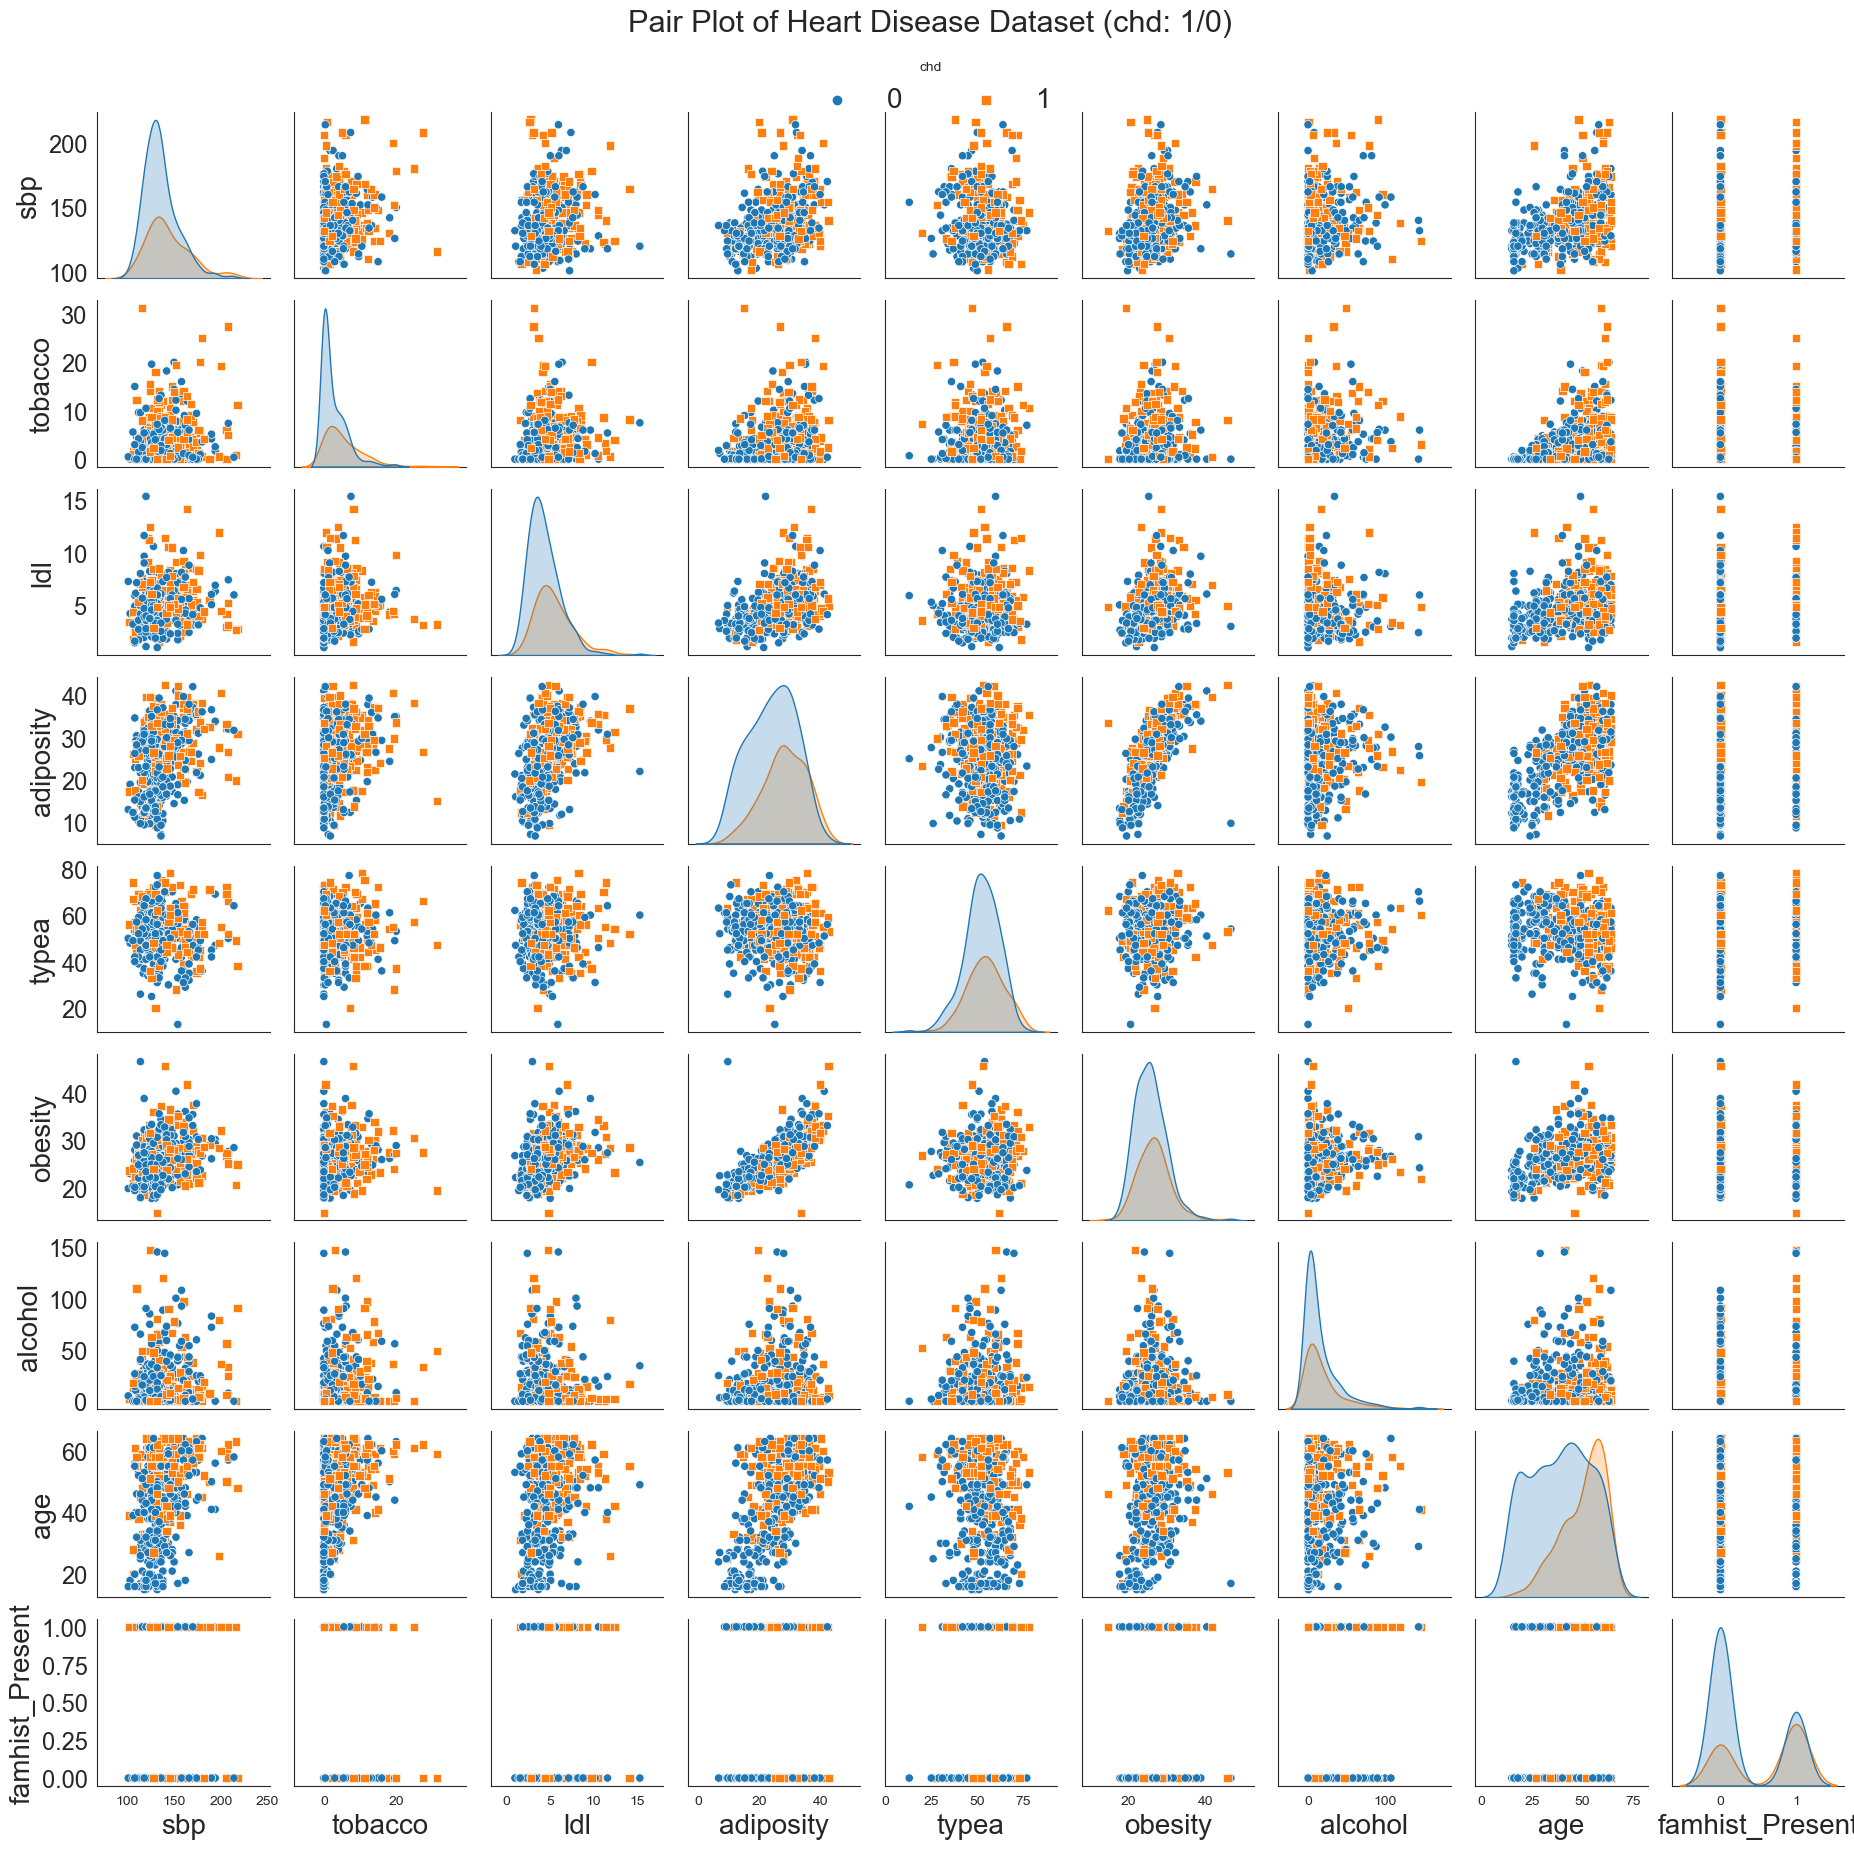

In [10]:
# Set style to remove grid lines
sns.set_style("white")
# Create a pair plot to visualize relationships between different features and species
ax = sns.pairplot(dataset, hue='chd', markers=["o", "s"], height=2)  # Adjust the height as needed
plt.suptitle("Pair Plot of Heart Disease Dataset (chd: 1/0)", y=1.025, fontsize=22)  # Increase y-coordinate to avoid overlapping with the pair plot and reduce font size
sns.move_legend(ax, "upper center", bbox_to_anchor=(0.5,1.01), ncol=2, frameon=False, fontsize= 20)

# Access x and y axis labels and adjust font size
for ax in ax.axes.flat:
    ax.set_xlabel(ax.get_xlabel(), fontsize=20)
    ax.set_ylabel(ax.get_ylabel(), fontsize=20)
    # Adjust y-axis tick labels font size
    for tick in ax.get_yticklabels():
        tick.set_fontsize(17)
plt.tight_layout()
plt.show()

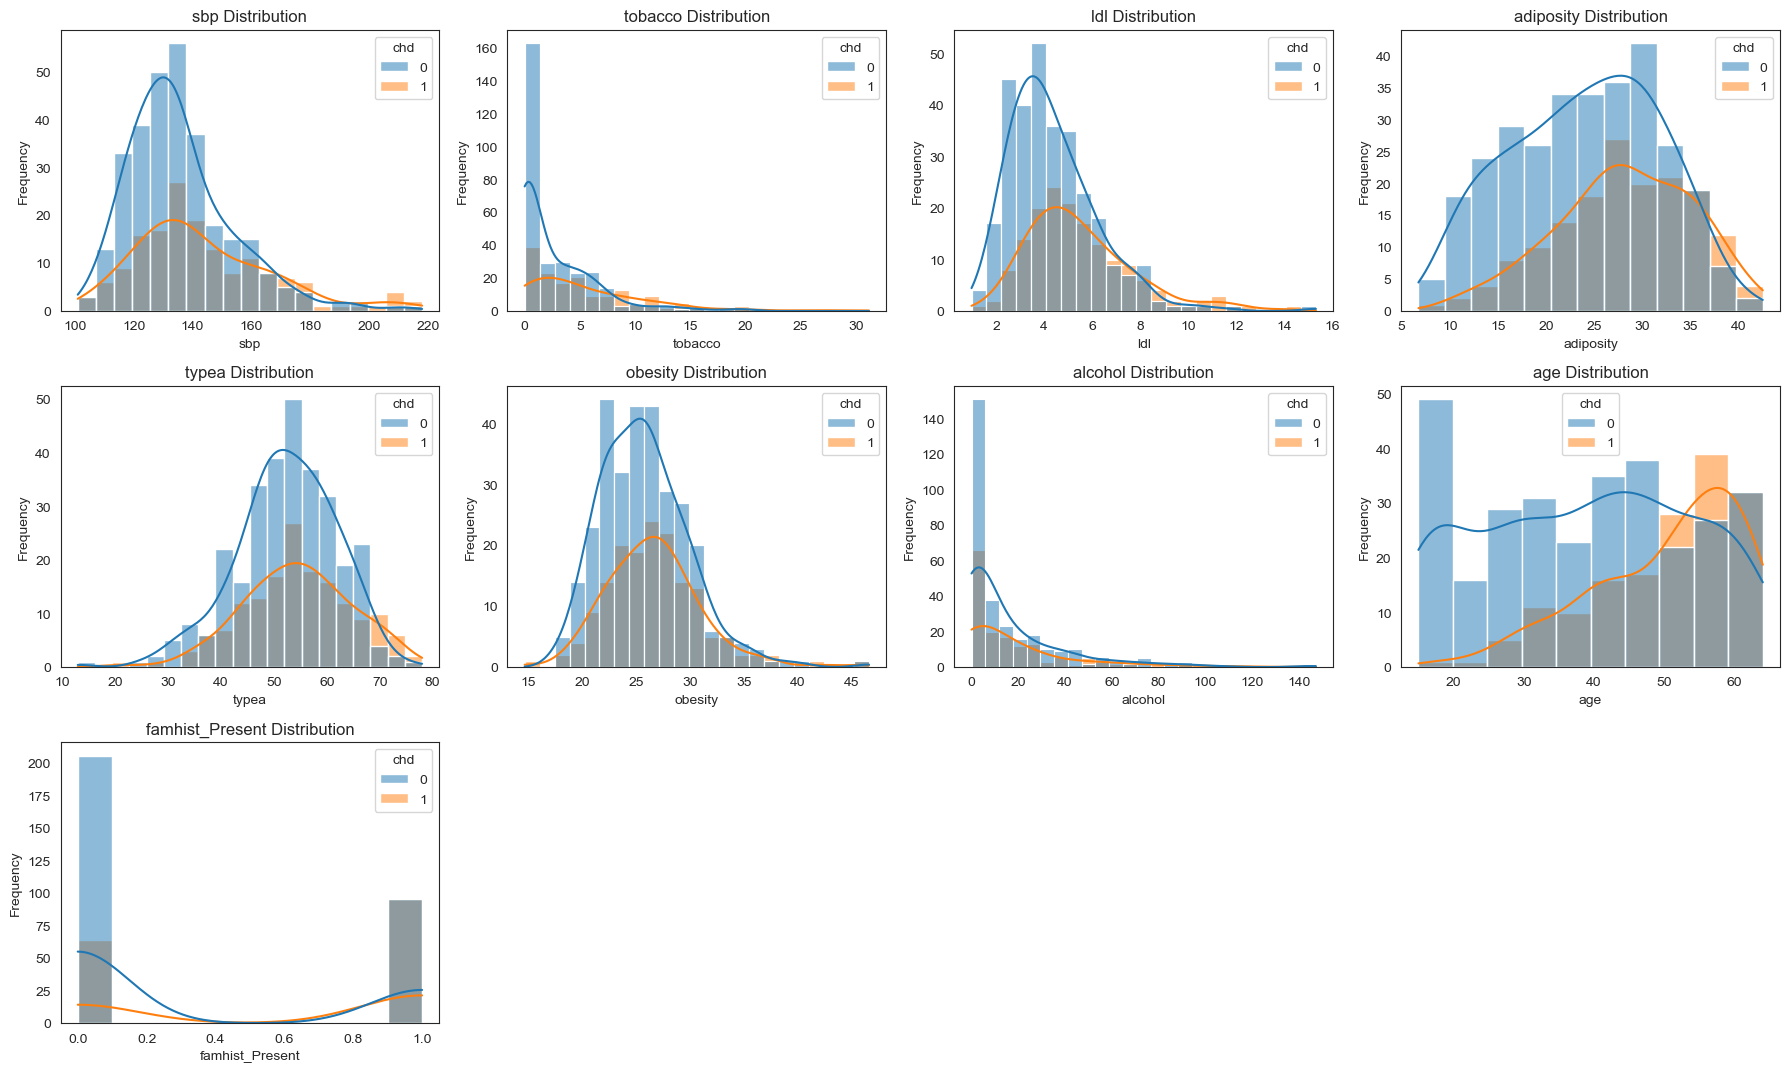

In [11]:
# Set the size of the figure
plt.figure(figsize=(18, 14))

# Iterate over each feature in X and plot histograms
for i, feature in enumerate(X.columns):
    # Create subplots with 3 rows, 3 columns, and incrementally increasing index
    plt.subplot(4, 4, i + 1)
    
    # Plot a histogram with kernel density estimation (KDE) using seaborn
    sns.histplot(data=dataset, x=X[feature], hue='chd', kde=True)
    
    # Set the title of the subplot based on the feature name
    plt.title(f'{feature} Distribution')
    
    # Set the label for the x-axis
    plt.xlabel(feature)
    
    # Set the label for the y-axis
    plt.ylabel('Frequency')

# Adjust the layout to make subplots fit without overlapping
plt.tight_layout()

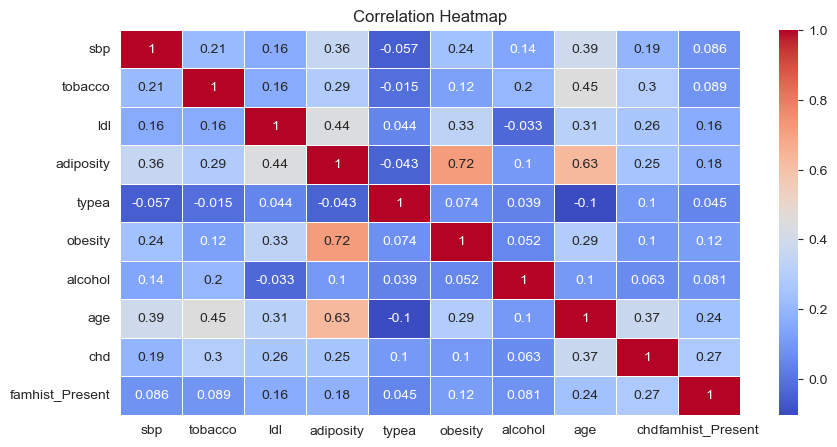

In [12]:
# Compute the correlation matrix using only numeric columns
correlation_matrix = dataset.corr(numeric_only=True)

# Set the size of the figure
plt.figure(figsize=(10, 5))

# Plot a heatmap of the correlation matrix using seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Set the title of the plot
plt.title("Correlation Heatmap")

# Display the plot
plt.show()

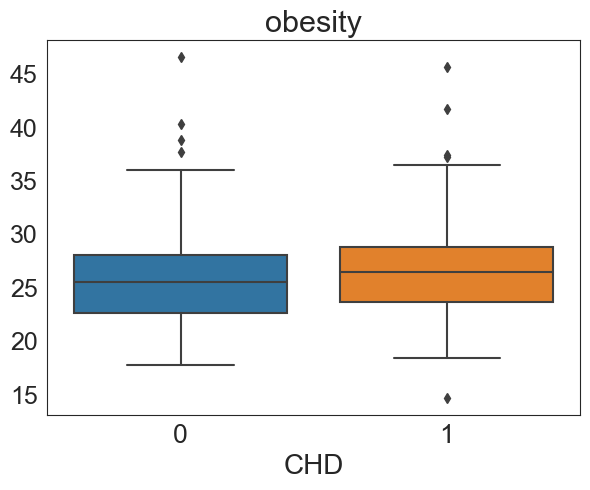

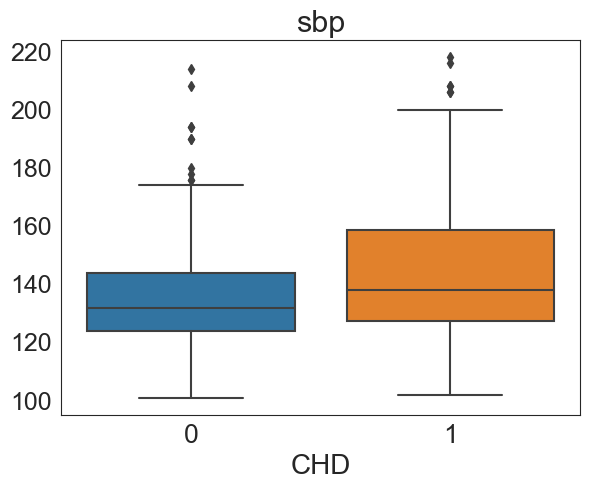

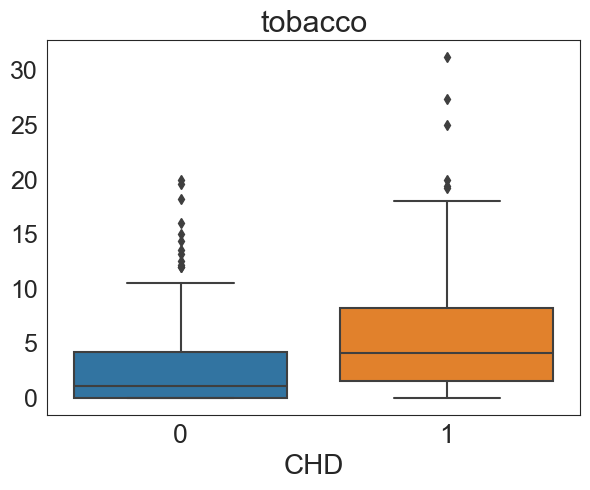

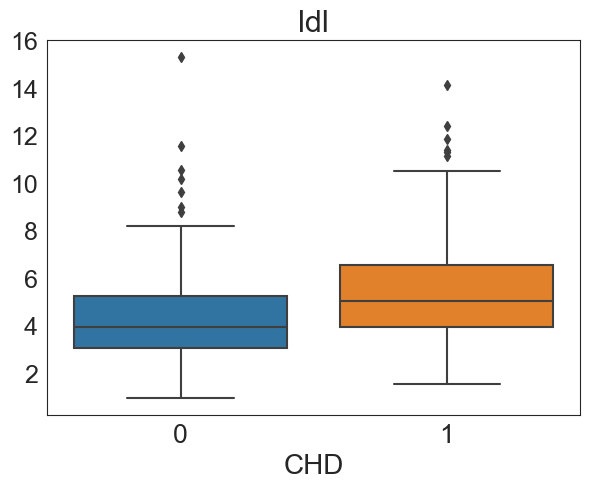

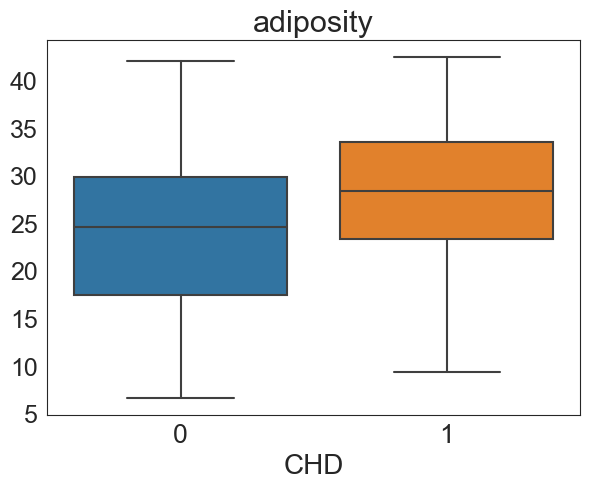

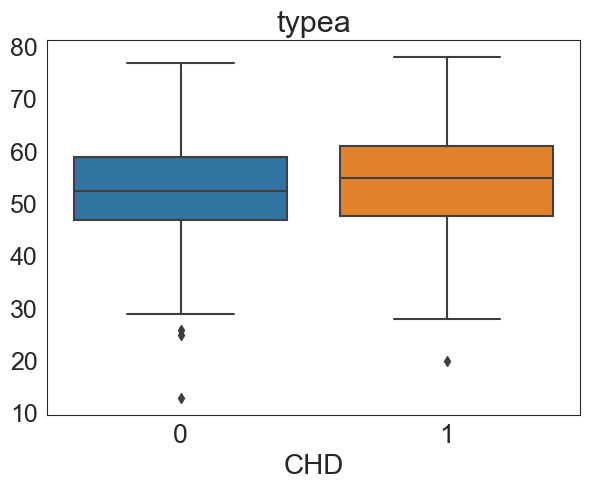

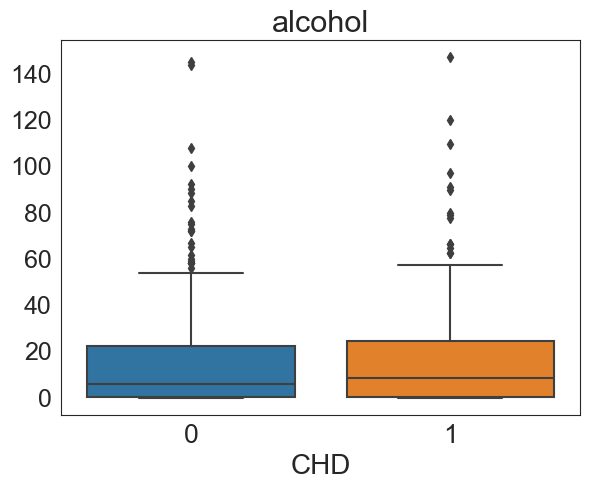

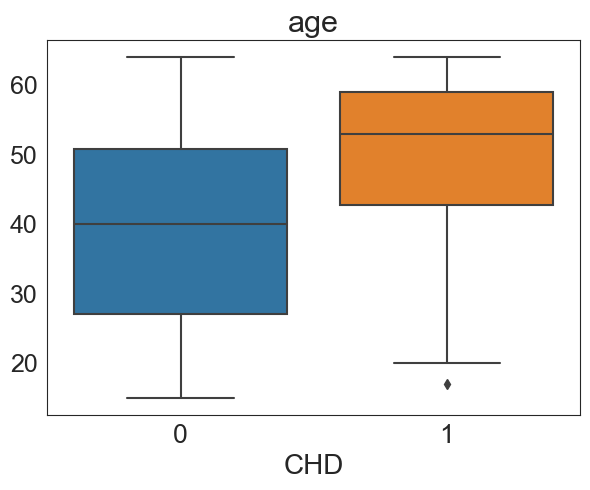

In [13]:
dataset_melt = pd.melt(dataset, id_vars=['chd'], var_name="Features", value_vars=['obesity', 'sbp',  'tobacco',   'ldl',  'adiposity',  'typea',  'alcohol',  'age'], value_name="Value")

features = dataset_melt['Features'].unique()

# Number of features to plot
n_features = len(features)

# Loop through each feature to create separate box plots
for i, feature in enumerate(features):
    plt.figure(figsize=(6, 5))  # Adjust the figure size as necessary
    sns.boxplot(x='chd', y='Value', data=dataset_melt[dataset_melt['Features'] == feature])
    plt.title(feature, fontsize= 22)
    plt.xlabel('CHD', fontsize= 20)  # Set the x-axis label to 'CHD' or remove it with ''
    plt.ylabel('')  # Set the y-axis label to 'Value' or adjust as necessary
    plt.xticks(fontsize= 19)
    plt.yticks(fontsize= 18)
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

    # Logic to simulate a new row after every 4th plot for visual separation
    if (i + 1) % 4 == 0 and (i + 1) < n_features:
        print("\n\n")  # This adds space after every 4th plot; adjust as needed for visual layout

# LOGISTIC REGRESSION WITH RIDGE PENALTY

In [14]:
# Split the dataset into training and testing sets for features (X) and target variable (y)
# Use 70% of the data for training and 30% for testing
# Set random_state to 42 for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [15]:
# Initialize the StandardScaler object with mean and standard deviation scaling
scaler = StandardScaler(with_mean=True, with_std=True, copy=True)

# Fit the scaler to the training data to compute mean and standard deviation
scaler.fit(X_train)

# Scale the training features using the computed mean and standard deviation
X_train = scaler.transform(X_train)

# Scale the test features using the same mean and standard deviation as the training data
X_test = scaler.transform(X_test)

In [16]:
# Generate a range of values for the regularization parameter C
Cs = np.logspace(-5, 1, 500)

# Define the parameters grid for GridSearchCV
parameters = {'C': Cs}

# Initialize GridSearchCV with Logistic Regression classifier, L2 penalty, and specified parameters
# Use 10-fold cross-validation and accuracy as the scoring metric
clf_GS = GridSearchCV(LogisticRegression(penalty='l2'), parameters, cv=10, scoring='accuracy')

# Fit the GridSearchCV object to the training data
clf_GS.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-05, 1.02807322e-05, 1.05693455e-05, 1.08660611e-05,
       1.11711065e-05, 1.14847155e-05, 1.18071285e-05, 1.21385926e-05,
       1.24793621e-05, 1.28296980e-05, 1.31898690e-05, 1.35601511e-05,
       1.39408283e-05, 1.43321923e-05, 1.47345431e-05, 1.51481892e-05,
       1.55734477e-05, 1.60106446e-05, 1.64601...
       5.28989308e+00, 5.43839743e+00, 5.59107078e+00, 5.74803016e+00,
       5.90939590e+00, 6.07529169e+00, 6.24584471e+00, 6.42118571e+00,
       6.60144909e+00, 6.78677305e+00, 6.97729965e+00, 7.17317494e+00,
       7.37454909e+00, 7.58157646e+00, 7.79441575e+00, 8.01323013e+00,
       8.23818733e+00, 8.46945981e+00, 8.70722485e+00, 8.95166472e+00,
       9.20296681e+00, 9.46132376e+00, 9.72693362e+00, 1.00000000e+01])},
             scoring='accuracy')

In [17]:
# Extract the best value of the regularization parameter C from the GridSearchCV results
best_Cc = clf_GS.best_params_['C']

In [18]:
# Initialize a Logistic Regression classifier with default parameters
LG= LogisticRegression()

In [19]:
# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize a list to store error rates, accuracies, precisions, ROC AUC and F1-scores for each fold
error_rates = []
accuracies = []
precisions = []
recalls = []
f1_scores = []
roc_auc_scores = []

# Initialize the StandardScaler
scaler = StandardScaler(with_mean=True, with_std=True, copy=True)

# Iterate over each fold of cross-validation
for train_index, test_index in cv.split(X, y):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the scaler on the training data and transform both training and testing data
    scaler.fit(X_train_fold)
    X_train_fold_scaled = scaler.transform(X_train_fold)
    X_test_fold_scaled = scaler.transform(X_test_fold)
    
    # Train the final model with the best C value
    final_model_lr_CV = LogisticRegression(penalty='l2', C=best_Cc, max_iter=500)  # Replace best_C with the actual best value
    final_model_lr_CV.fit(X_train_fold_scaled, y_train_fold)               
   
    # Predict on the test data
    pred_lr = final_model_lr_CV.predict(X_test_fold_scaled)
    predicted_probabilities_lr = final_model_lr_CV.predict_proba(X_test_fold_scaled)

    # Calculate the confusion matrix for this fold
    conf_matrix = confusion_matrix(y_test_fold, pred_lr)
    
    # Extract values from the confusion matrix
    tn, fp, fn, tp = conf_matrix.ravel()
    
    # Calculate error rate for this fold
    error_rate = (fp + fn) / len(y_test_fold)
    error_rates.append(error_rate)
    
    # Calculate accuracy for this fold
    accuracy = accuracy_score(y_test_fold, pred_lr)
    accuracies.append(accuracy)

    # Calculate F1-score for this fold
    f1 = f1_score(y_test_fold, pred_lr)
    f1_scores.append(f1)

    precision = precision_score(y_test_fold, pred_lr)
    precisions.append(precision)

    recall = recall_score(y_test_fold, pred_lr)
    recalls.append(recall)

    # Calculate ROC AUC for this fold
    fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test_fold, predicted_probabilities_lr[:, 1])
    roc_auclr = auc(fpr_lr, tpr_lr)
    roc_auc_scores.append(roc_auclr)

# Calculate average accuracy and average F1-score
average_accuracy = sum(accuracies) / len(accuracies)
average_f1_score = sum(f1_scores) / len(f1_scores)
average_error_rates= sum(error_rates) / len(error_rates)
average_precision = sum(precisions) / len(precisions)
average_recall = sum(recalls) / len(recalls)
average_roc_auc = np.mean(roc_auc_scores)

# Print average performance metrics
print(f"Average Accuracy LR: {average_accuracy:.4f}")
print(f"Average F1-score LR: {average_f1_score:.4f}")
print(f"Average Error rates LR: {average_error_rates:.4f}")
print(f"Average Precision LR: {average_precision:.4f}")
print(f"Average Recall LR: {average_recall:.4f}")
print(f"Average ROC AUC LR: {average_roc_auc:.4f}")

Average Accuracy LR: 0.7319
Average F1-score LR: 0.5512
Average Error rates LR: 0.2681
Average Precision LR: 0.6662
Average Recall LR: 0.4875
Average ROC AUC LR: 0.7731


In [20]:
X_train_new=sm.add_constant(X_train, prepend=False) 
# fit a GLM model with binomial family
lrs=sm.GLM(y_train,X_train_new,family=sm.families.Binomial()).fit()
print(lrs.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    chd   No. Observations:                  323
Model:                            GLM   Df Residuals:                      313
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -166.49
Date:                Wed, 20 Mar 2024   Deviance:                       332.99
Time:                        23:21:47   Pearson chi2:                     320.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2258
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1971      0.138      1.427      0.1

# LDA

In [21]:
# Split the dataset into training and testing sets for features (X) and target variable (y)
# Use 70% of the data for training and 30% for testing
# Set random_state to 42 for reproducibility
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3, random_state=42)

In [22]:
# Initialize a Linear Discriminant Analysis (LDA) classifier
lda = LDA()

In [23]:
# Define the cross-validation strategy
cv_lda = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize a list to store error rates, accuracies, precisions, recalls, roc auc and F1-scores for each fold
error_rates_lda = []
accuracies_lda = []
precisions_lda = []
recalls_lda = []
f1_scores_lda = []
roc_auc_scores_lda = []

# Iterate over each fold of cross-validation
for train_index, test_index in cv_lda.split(X, y):
    X_train_fold_lda, X_test_fold_lda = X.iloc[train_index], X.iloc[test_index]
    y_train_fold_lda, y_test_fold_lda = y.iloc[train_index], y.iloc[test_index]
     
    # Train the final model with the best C value
    lda.fit(X_train_fold_lda, y_train_fold_lda)       
   
    # Predict on the test data
    pred_lda = lda.predict(X_test_fold_lda)
    predicted_probabilities_lda = lda.predict_proba(X_test_fold_lda)

    # Calculate the confusion matrix for this fold
    conf_matrixlda = confusion_matrix(y_test_fold_lda, pred_lda)
    
    # Extract values from the confusion matrix
    tn_lda, fp_lda, fn_lda, tp_lda = conf_matrixlda.ravel()
    
    # Calculate error rate for this fold
    error_rate_lda = (fp_lda + fn_lda) / len(y_test_fold_lda)
    error_rates_lda.append(error_rate_lda)
 
    # Calculate accuracy for this fold
    accuracy_lda = accuracy_score(y_test_fold_lda, pred_lda)
    accuracies_lda.append(accuracy_lda)

    # Calculate F1-score for this fold
    f1_lda = f1_score(y_test_fold_lda, pred_lda)
    f1_scores_lda.append(f1_lda)

    precision_lda = precision_score(y_test_fold_lda, pred_lda)
    precisions_lda.append(precision_lda)

    recall_lda = recall_score(y_test_fold_lda, pred_lda)
    recalls_lda.append(recall_lda)

    # Calculate ROC AUC for this fold
    fpr_lda, tpr_lda, thresholds_lda = roc_curve(y_test_fold_lda, predicted_probabilities_lda[:, 1])
    roc_auc_lda = auc(fpr_lda, tpr_lda)
    roc_auc_scores_lda.append(roc_auc_lda)

# Calculate average accuracy and average F1-score
average_accuracy_lda = sum(accuracies_lda) / len(accuracies_lda)
average_f1_score_lda = sum(f1_scores_lda) / len(f1_scores_lda)
average_error_rates_lda= sum(error_rates_lda) / len(error_rates_lda)
average_precision_lda = sum(precisions_lda) / len(precisions_lda)
average_recall_lda = sum(recalls_lda) / len(recalls_lda)
average_roc_auc_lda = np.mean(roc_auc_scores_lda)

# Print average performance metrics
print(f"Average Accuracy LDA: {average_accuracy_lda:.4f}")
print(f"Average F1-score LDA: {average_f1_score_lda:.4f}")
print(f"Average Error rates LDA: {average_error_rates_lda:.4f}")
print(f"Average Precision LDA: {average_precision_lda:.4f}")
print(f"Average Recall LDA: {average_recall_lda:.4f}")
print(f"Average ROC AUC LDA: {average_roc_auc_lda:.4f}")

Average Accuracy LDA: 0.7233
Average F1-score LDA: 0.5590
Average Error rates LDA: 0.2767
Average Precision LDA: 0.6421
Average Recall LDA: 0.5125
Average ROC AUC LDA: 0.7708


# SVM

In [24]:
# Create a copy of the dataset to avoid modifying the original dataset
dataset2 = dataset.copy()

# Replace labels in the 'chd' column: 1 with 1, 0 with -1 to enable roc_curve function
dataset2['chd'].replace((1, 0), (1, -1), inplace=True)

In [25]:
# Create feature matrix X2 by dropping the 'chd' column from the modified dataset
X2 = dataset2.drop(columns=['chd'])

# Create target variable y2 by selecting only the 'chd' column from the modified dataset
y2 = dataset2['chd']

In [26]:
# Split the modified dataset into training and testing sets for features (X2) and target variable (y2)
# Use 70% of the data for training and 30% for testing
# Set random_state to 42 for reproducibility
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=42)

In [27]:
# Initialize the StandardScaler object with mean and standard deviation scaling
scaler_svm = StandardScaler(with_mean=True, with_std=True, copy=True) #scale training and test features

# Fit the scaler to the training data to compute mean and standard deviation
scaler_svm.fit(X_train2) 

# Scale the training features using the computed mean and standard deviation
X_train2 = scaler_svm.transform(X_train2)

# Scale the test features using the same mean and standard deviation as the training data
X_test2 = scaler_svm.transform(X_test2)

In [28]:
# Apply SVM with RBF kernel and tune gamma and C
tuned_parameters_rbf = [{"kernel": ["rbf"], "gamma": [1,1e-1,1e-2,1e-3, 1e-4], "C": [1, 10, 100,1000]}] # gamma ranges from 1 (high) to 0.0001 (low)
svmCV = GridSearchCV(SVC(), tuned_parameters_rbf, scoring='accuracy',cv=10)
svmCV.fit(X_train2, y_train2)
print("Best parameters set found on development set:")
print()
print(svmCV.best_params_)
print()
print("Grid scores on development set:")
print()
means_svm = svmCV.cv_results_["mean_test_score"]
stds_svm = svmCV.cv_results_["std_test_score"]
for mean, std, params in zip(means_svm, stds_svm, svmCV.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std, params))

Best parameters set found on development set:

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

Grid scores on development set:

0.650 (+/-0.024) for {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.705 (+/-0.078) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.708 (+/-0.069) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.656 (+/-0.008) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.656 (+/-0.008) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.647 (+/-0.040) for {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
0.687 (+/-0.081) for {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.746 (+/-0.050) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.696 (+/-0.074) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.656 (+/-0.008) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.647 (+/-0.040) for {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
0.622 (+/-0.050) for {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
0.724 (+/-0.080) for {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
0.733 (+/-0.053) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0

In [29]:
# Extract the best values of the hyperparameters gamma and C from the GridSearchCV results for SVM
best_gamma = svmCV.best_params_['gamma']
best_Csvm = svmCV.best_params_['C']

In [30]:
# Define the cross-validation strategy
cv_svm = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize a list to store error rates for each fold
error_rates_svm = []
accuracies_svm = []
precisions_svm = []
recalls_svm = []
f1_scores_svm = []
roc_auc_scores_svm = []

# Initialize the StandardScaler
scaler_svm = StandardScaler(with_mean=True, with_std=True, copy=True)

# Iterate over each fold of cross-validation
for train_index, test_index in cv_svm.split(X2, y2):
    X_train_fold_svm, X_test_fold_svm = X2.iloc[train_index], X2.iloc[test_index]
    y_train_fold_svm, y_test_fold_svm = y2.iloc[train_index], y2.iloc[test_index]
    
    # Fit the scaler on the training data and transform both training and testing data
    scaler_svm.fit(X_train_fold_svm)
    X_train_fold_scaled_svm = scaler_svm.transform(X_train_fold_svm)
    X_test_fold_scaled_svm = scaler_svm.transform(X_test_fold_svm)
    
    # Train the final model with the best C value
    final_model_svm = SVC(C=best_Csvm, gamma=best_gamma, probability=True)  # Replace best_C with the actual best value
    final_model_svm.fit(X_train_fold_scaled_svm, y_train_fold_svm)                             

    # Predict on the test data
    pred_svm = final_model_svm.predict(X_test_fold_scaled_svm)
    predicted_probabilities_svm = final_model_svm.predict_proba(X_test_fold_scaled_svm)
    
    # Calculate the confusion matrix for this fold
    conf_matrix_svm = confusion_matrix(y_test_fold_svm, pred_svm)

    # Extract values from the confusion matrix
    tn_svm, fp_svm, fn_svm, tp_svm = conf_matrix_svm.ravel()

    # Calculate error rate for this fold
    error_rate_svm = (fp_svm + fn_svm) / len(y_test_fold_svm)
    error_rates_svm.append(error_rate_svm)

    # Calculate accuracy for this fold
    accuracy_svm = accuracy_score(y_test_fold_svm, pred_svm)
    accuracies_svm.append(accuracy_svm)

    # Calculate F1-score for this fold
    f1_svm = f1_score(y_test_fold_svm, pred_svm)
    f1_scores_svm.append(f1_svm)

    # Calculate precision for this fold
    precision_svm = precision_score(y_test_fold_svm, pred_svm)
    precisions_svm.append(precision_svm)

    # Calculate recall for this fold
    recall_svm = recall_score(y_test_fold_svm, pred_svm)
    recalls_svm.append(recall_svm)

    # Calculate ROC AUC for this fold
    fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test_fold_svm, predicted_probabilities_svm[:, 1])
    roc_auc_svm = auc(fpr_svm, tpr_svm)
    roc_auc_scores_svm.append(roc_auc_svm)

# Calculate average accuracy and average F1-score
average_accuracy_svm = sum(accuracies_svm) / len(accuracies_svm)
average_f1_score_svm = sum(f1_scores_svm) / len(f1_scores_svm)
average_error_rates_svm= sum(error_rates_svm) / len(error_rates_svm)
average_precision_svm = sum(precisions_svm) / len(precisions_svm)
average_recall_svm = sum(recalls_svm) / len(recalls_svm)
average_roc_auc_svm= np.mean(roc_auc_scores_svm)

# Print average performance metrics
print(f"Average Accuracy SVM: {average_accuracy_svm:.4f}")
print(f"Average F1-score SVM: {average_f1_score_svm:.4f}")
print(f"Average Error rates SVM: {average_error_rates_svm:.4f}")
print(f"Average Precision SVM: {average_precision_svm:.4f}")
print(f"Average Recall SVM: {average_recall_svm:.4f}")
print(f"Average ROC AUC SVM: {average_roc_auc_svm:.4f}")

Average Accuracy SVM: 0.7253
Average F1-score SVM: 0.5346
Average Error rates SVM: 0.2747
Average Precision SVM: 0.6609
Average Recall SVM: 0.4562
Average ROC AUC SVM: 0.7755


# QDA

In [31]:
# Split the modified dataset into training and testing sets for features (X2) and target variable (y2)
# Use 70% of the data for training and 30% for testing
# Set random_state to 42 for reproducibility
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=0.3, random_state=42)

In [32]:
# Initialize a Quadratic Discriminant Analysis (QDA) classifier
qda = QDA()

In [33]:
# Define the cross-validation strategy
cv_qda = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize a list to store error rates, accuracies, precisions, recalls, roc auc and F1-scores for each fold
error_rates_qda = []
accuracies_qda = []
precisions_qda = []
recalls_qda = []
f1_scores_qda = []
roc_auc_scores_qda = []

# Iterate over each fold of cross-validation
for train_index, test_index in cv_qda.split(X, y):
    X_train_fold_qda, X_test_fold_qda = X.iloc[train_index], X.iloc[test_index]
    y_train_fold_qda, y_test_fold_qda = y.iloc[train_index], y.iloc[test_index]

    # Train the final model with the best C value
    qda.fit(X_train_fold_qda, y_train_fold_qda)       
   
    # Predict on the test data
    pred_qda = qda.predict(X_test_fold_qda)
    predicted_probabilities_qda = qda.predict_proba(X_test_fold_qda)

    # Calculate the confusion matrix for this fold
    conf_matrixqda = confusion_matrix(y_test_fold_qda, pred_qda)

    # Extract values from the confusion matrix
    tn_qda, fp_qda, fn_qda, tp_qda = conf_matrixqda.ravel()
    
    # Calculate error rate for this fold
    error_rate_qda = (fp_qda + fn_qda) / len(y_test_fold_qda)
    error_rates_qda.append(error_rate_qda)
 
    # Calculate accuracy for this fold
    accuracy_qda = accuracy_score(y_test_fold_qda, pred_qda)
    accuracies_qda.append(accuracy_qda)

    # Calculate F1-score for this fold
    f1_qda = f1_score(y_test_fold_qda, pred_qda)
    f1_scores_qda.append(f1_qda)

    # Calculate precision for this fold
    precision_qda = precision_score(y_test_fold_qda, pred_qda)
    precisions_qda.append(precision_qda)

    # Calculate F1-recall for this fold
    recall_qda = recall_score(y_test_fold_qda, pred_qda)
    recalls_qda.append(recall_qda)

    # Calculate ROC AUC for this fold
    fpr_qda, tpr_qda, thresholds_qda = roc_curve(y_test_fold_qda, predicted_probabilities_qda[:, 1])
    roc_auc_qda = auc(fpr_qda, tpr_qda)
    roc_auc_scores_qda.append(roc_auc_qda)

# Calculate average accuracy and average F1-score
average_accuracy_qda = sum(accuracies_qda) / len(accuracies_qda)
average_f1_score_qda = sum(f1_scores_qda) / len(f1_scores_qda)
average_error_rates_qda= sum(error_rates_qda) / len(error_rates_qda)
average_precision_qda = sum(precisions_qda) / len(precisions_qda)
average_recall_qda = sum(recalls_qda) / len(recalls_qda)
average_roc_auc_qda = np.mean(roc_auc_scores_qda)

# Print average performance metrics
print(f"Average Accuracy QDA: {average_accuracy_qda:.4f}")
print(f"Average F1-score QDA: {average_f1_score_qda:.4f}")
print(f"Average Error rates QDA: {average_error_rates_qda:.4f}")
print(f"Average Precision QDA: {average_precision_qda:.4f}")
print(f"Average Recall QDA: {average_recall_qda:.4f}")
print(f"Average ROC AUC QDA: {average_roc_auc_qda:.4f}")


Average Accuracy QDA: 0.7100
Average F1-score QDA: 0.5430
Average Error rates QDA: 0.2900
Average Precision QDA: 0.5926
Average Recall QDA: 0.5125
Average ROC AUC QDA: 0.7372


# KNN

In [34]:
# Split the modified dataset into training and testing sets for features (X2) and target variable (y2)
# Use 70% of the data for training and 30% for testing
# Set random_state to 42 for reproducibility
X_train4, X_test4, y_train4, y_test4 = train_test_split(X, y, test_size=0.3, random_state=42)

In [35]:
# Initialize the StandardScaler object with mean and standard deviation scaling
scaler = StandardScaler(with_mean=True, with_std=True, copy=True) #scale training and test features

# Fit the scaler to the training data to compute mean and standard deviation
scaler.fit(X_train4) 

# Scale the training features using the computed mean and standard deviation
X_train4 = scaler.transform(X_train4)

# Scale the test features using the same mean and standard deviation as the training data
X_test4 = scaler.transform(X_test4)

In [36]:
# Set tuning values
tuned_parameters = [{"n_neighbors": [5,10,15,20,21,22,23,24,25,26,27,28,29,30]}]
# Tune the parameter by k-fold cross-validation
knnCV = GridSearchCV(KNeighborsClassifier(), tuned_parameters, scoring='roc_auc',cv=5)
knnCV.fit(X_train4, y_train4)
print("Best parameters set found on validation set:")
print()
print(knnCV.best_params_)
print()
print("Grid scores on validation set:")
print()
means = knnCV.cv_results_["mean_test_score"]
stds = knnCV.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, knnCV.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std, params))

Best parameters set found on validation set:

{'n_neighbors': 21}

Grid scores on validation set:

0.630 (+/-0.083) for {'n_neighbors': 5}
0.699 (+/-0.059) for {'n_neighbors': 10}
0.738 (+/-0.063) for {'n_neighbors': 15}
0.758 (+/-0.068) for {'n_neighbors': 20}
0.765 (+/-0.060) for {'n_neighbors': 21}
0.763 (+/-0.054) for {'n_neighbors': 22}
0.763 (+/-0.056) for {'n_neighbors': 23}
0.760 (+/-0.054) for {'n_neighbors': 24}
0.757 (+/-0.056) for {'n_neighbors': 25}
0.755 (+/-0.056) for {'n_neighbors': 26}
0.757 (+/-0.052) for {'n_neighbors': 27}
0.756 (+/-0.056) for {'n_neighbors': 28}
0.752 (+/-0.056) for {'n_neighbors': 29}
0.751 (+/-0.052) for {'n_neighbors': 30}


In [37]:
# Extract the best value of the hyperparameter n_neighbors from the GridSearchCV results for KNN
best_KNN= knnCV.best_params_['n_neighbors']

In [38]:
# Define the cross-validation strategy
cv_KNN = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize a list to store error rates, accuracies, precisions, recalls, roc auc and F1-scores for each fold
error_rates_KNN = []
accuracies_KNN = []
precisions_KNN = []
recalls_KNN = []
f1_scores_KNN = []
roc_auc_scores_KNN = []

# Initialize the StandardScaler
scaler_knn = StandardScaler(with_mean=True, with_std=True, copy=True)

# Iterate over each fold of cross-validation
for train_index, test_index in cv_KNN.split(X, y):
    X_train_fold_KNN, X_test_fold_KNN = X.iloc[train_index], X.iloc[test_index]
    y_train_fold_KNN, y_test_fold_KNN = y.iloc[train_index], y.iloc[test_index]

    # Fit the scaler on the training data and transform both training and testing data
    scaler_knn.fit(X_train_fold_KNN)
    X_train_fold_scaled_knn = scaler_knn.transform(X_train_fold_KNN)
    X_test_fold_scaled_knn = scaler_knn.transform(X_test_fold_KNN)
    
    # Initialize the final KNN model with the best value of n_neighbors
    final_model_KNN = KNeighborsClassifier(n_neighbors=best_KNN)
    
    # Fit the final KNN model to the scaled training data
    final_model_KNN.fit(X_train_fold_scaled_knn, y_train_fold_KNN)      
   
    # Predict on the test data
    pred_KNN = final_model_KNN.predict(X_test_fold_scaled_knn)
    predicted_probabilities_KNN = final_model_KNN.predict_proba(X_test_fold_scaled_knn)

    # Calculate the confusion matrix for this fold
    conf_matrixknn = confusion_matrix(y_test_fold_KNN, pred_KNN)
    
    # Extract values from the confusion matrix
    tn_knn, fp_knn, fn_knn, tp_knn = conf_matrixknn.ravel()

    # Calculate error rate for this fold
    error_rate_knn = (fp_knn + fn_knn) / len(y_test_fold_KNN)
    error_rates_KNN.append(error_rate_knn)
    
    # Calculate accuracy for this fold
    accuracy_knn = accuracy_score(y_test_fold_KNN, pred_KNN)
    accuracies_KNN.append(accuracy_knn)

    # Calculate F1-score for this fold
    f1_KNN = f1_score(y_test_fold_KNN, pred_KNN)
    f1_scores_KNN.append(f1_KNN)
    
    # Calculate precision for this fold
    precision_KNN = precision_score(y_test_fold_KNN, pred_KNN)
    precisions_KNN.append(precision_KNN)

    # Calculate recall for this fold
    recall_KNN = recall_score(y_test_fold_KNN, pred_KNN)
    recalls_KNN.append(recall_KNN)

    # Calculate ROC AUC for this fold
    fpr_KNN, tpr_KNN, thresholds_KNN = roc_curve(y_test_fold_KNN, predicted_probabilities_KNN[:, 1])
    roc_auc_KNN = auc(fpr_KNN, tpr_KNN)
    roc_auc_scores_KNN.append(roc_auc_KNN)

# Calculate average accuracy and average F1-score
average_accuracy_KNN = sum(accuracies_KNN) / len(accuracies_KNN)
average_f1_score_KNN = sum(f1_scores_KNN) / len(f1_scores_KNN)
average_error_rates_KNN= sum(error_rates_KNN) / len(error_rates_KNN)
average_precision_KNN = sum(precisions_KNN) / len(precisions_KNN)
average_recall_KNN = sum(recalls_KNN) / len(recalls_KNN)
average_roc_auc_KNN = np.mean(roc_auc_scores_KNN)

# Print average performance metrics
print(f"Average Accuracy CV-KNN: {average_accuracy_KNN:.4f}")
print(f"Average F1-score CV-KNN: {average_f1_score_KNN:.4f}")
print(f"Average Error rates CV-KNN: {average_error_rates_KNN:.4f}")
print(f"Average Precision CV-KNN: {average_precision_KNN:.4f}")
print(f"Average Recall CV-KNN: {average_recall_KNN:.4f}")
print(f"Average ROC AUC CV-KNN: {average_roc_auc_KNN:.4f}")

Average Accuracy CV-KNN: 0.7187
Average F1-score CV-KNN: 0.4704
Average Error rates CV-KNN: 0.2813
Average Precision CV-KNN: 0.6852
Average Recall CV-KNN: 0.3688
Average ROC AUC CV-KNN: 0.7440


# NAIVE BAYES

In [39]:
# Split the modified dataset into training and testing sets for features (X2) and target variable (y2)
# Use 70% of the data for training and 30% for testing
# Set random_state to 42 for reproducibility
X_train5, X_test5, y_train5, y_test5 = train_test_split(X, y, test_size=0.3, random_state=42)

In [40]:
# Initialize a Gaussian Naive Bayes classifier
NB = GaussianNB()

In [41]:
# Define the cross-validation strategy
cv_nb = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize a list to store error rates, accuracies, precisions, recalls, roc auc and F1-scores for each fold
error_rates_NB = []
accuracies_NB = []
precisions_NB = []
recalls_NB = []
f1_scores_NB = []
roc_auc_scores_NB = []

# Iterate over each fold of cross-validation
for train_index, test_index in cv_nb.split(X, y):
    X_train_fold_nb, X_test_fold_nb = X.iloc[train_index], X.iloc[test_index]
    y_train_fold_nb, y_test_fold_nb = y.iloc[train_index], y.iloc[test_index]
     
    # Train the final model with the best C value
    NB.fit(X_train_fold_nb, y_train_fold_nb)       
   
    # Predict on the test data
    pred_nb = NB.predict(X_test_fold_nb)
    predicted_probabilities_NB = NB.predict_proba(X_test_fold_nb)

    # Calculate the confusion matrix for this fold
    conf_matrixnb = confusion_matrix(y_test_fold_nb, pred_nb)
    
    # Extract values from the confusion matrix
    tn_nb, fp_nb, fn_nb, tp_nb = conf_matrixnb.ravel()
    
    # Calculate error rate for this fold
    error_rate_nb = (fp_nb + fn_nb) / len(y_test_fold_nb)
    error_rates_NB.append(error_rate_nb)
 
    # Calculate accuracy for this fold
    accuracy_nb = accuracy_score(y_test_fold_nb, pred_nb)
    accuracies_NB.append(accuracy_nb)

    # Calculate F1-score for this fold
    f1_nb = f1_score(y_test_fold_nb, pred_nb)
    f1_scores_NB.append(f1_nb)

    # Calculate precision for this fold
    precision_nb = precision_score(y_test_fold_nb, pred_nb)
    precisions_NB.append(precision_nb)

    # Calculate recall for this fold
    recall_nb = recall_score(y_test_fold_nb, pred_nb)
    recalls_NB.append(recall_nb)

    # Calculate ROC AUC for this fold
    fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_test_fold_nb, predicted_probabilities_NB[:, 1])
    roc_auc_nb = auc(fpr_nb, tpr_nb)
    roc_auc_scores_NB.append(roc_auc_nb)

# Calculate average accuracy and average F1-score
average_accuracy_nb = sum(accuracies_NB) / len(accuracies_NB)
average_f1_score_nb = sum(f1_scores_NB) / len(f1_scores_NB)
average_error_rates_nb = sum(error_rates_NB) / len(error_rates_NB)
average_precision_nb = sum(precisions_NB) / len(precisions_NB)
average_recall_nb = sum(recalls_NB) / len(recalls_NB)
average_roc_auc_nb = np.mean(roc_auc_scores_NB)

# Print average performance metrics
print(f"Average Accuracy NB: {average_accuracy_nb:.4f}")
print(f"Average F1-score NB: {average_f1_score_nb:.4f}")
print(f"Average Error rates NB: {average_error_rates_nb:.4f}")
print(f"Average Precision NB: {average_precision_nb:.4f}")
print(f"Average Recall NB: {average_recall_nb:.4f}")
print(f"Average ROC AUC NB: {average_roc_auc_nb:.4f}")

Average Accuracy NB: 0.7146
Average F1-score NB: 0.5974
Average Error rates NB: 0.2854
Average Precision NB: 0.5848
Average Recall NB: 0.6188
Average ROC AUC NB: 0.7487


# VISUAL REPRESENTATION OF THE RESULTS

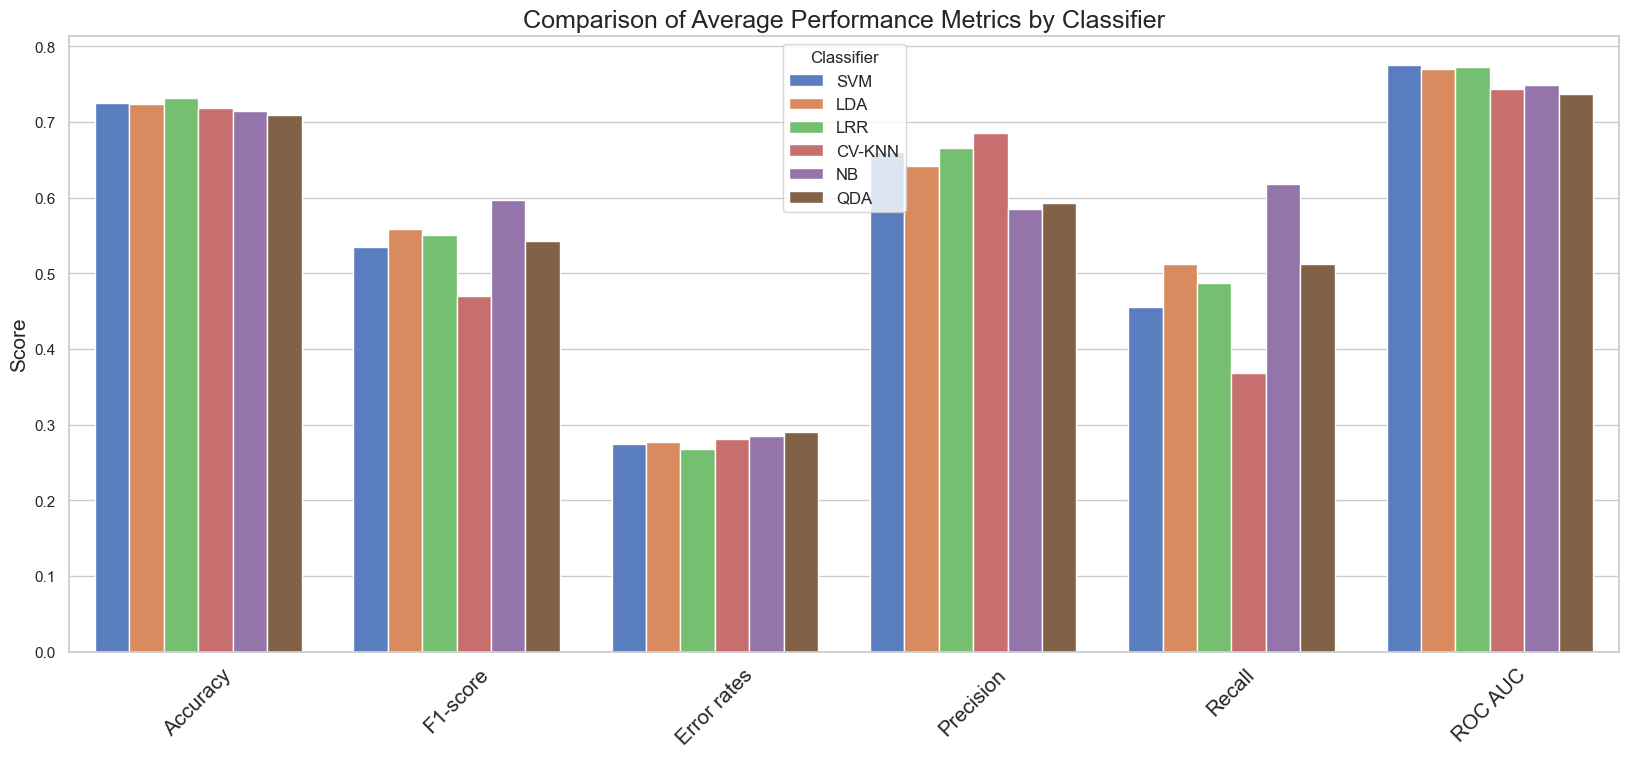

In [42]:
# Define the classifiers and their average performance metrics
classifiers = ['SVM', 'LDA', 'LRR', 'CV-KNN', 'NB', 'QDA']
accuracy = [0.7253, 0.7233, 0.7319, 0.7187, 0.7146, 0.7100]
f1_score = [0.5346, 0.5590, 0.5512, 0.4704, 0.5974,0.5430]
error_rates = [0.2747, 0.2767, 0.2681, 0.2813, 0.2854, 0.2900]
precision = [0.6609, 0.6421, 0.6662, 0.6852, 0.5848, 0.5926]
recall = [0.4562, 0.5125, 0.4875, 0.3688, 0.6188, 0.5125]
roc_auc = [0.7755, 0.7708, 0.7731, 0.7440, 0.7487, 0.7372]



# Create a dataframe to store the data
data = pd.DataFrame({'Classifier': classifiers,
                     'Accuracy': accuracy,
                     'F1-score': f1_score,
                     'Error rates': error_rates,
                     'Precision': precision,
                     'Recall': recall,
                     'ROC AUC': roc_auc})

# Melt the dataframe to have a long format for seaborn plotting
data_melted = pd.melt(data, id_vars='Classifier', var_name='Metric', value_name='Score')

# Set style
sns.set(style="whitegrid")

# Plot
plt.figure(figsize=(20, 8))
sns.barplot(x='Metric', y='Score', hue='Classifier', data=data_melted, palette='muted')
plt.title('Comparison of Average Performance Metrics by Classifier', fontsize= 18)
plt.xlabel('')
plt.ylabel('Score', fontsize=15)
plt.xticks(rotation=45, fontsize= 15)
plt.legend(title='Classifier', loc='upper center', fontsize= 12, title_fontsize= 12)
plt.show()